In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

In [2]:
def get_denver():
    if os.path.exists('denver.csv'):
        df = pd.read_csv('denver.csv',index_col=0)
    else:
        df = pd.read_csv('GlobalLandTemperaturesByCity.csv')
        df = df[df.City=='Denver']
        df.to_csv('denver.csv')
    return df

def prep_df(df):
    
    df.dt = pd.to_datetime(df.dt)
    df = df.set_index('dt')
    df = df.sort_index()
    df = df[['AverageTemperature']]
    df.columns = df.columns=['avg_temp']
    df['month'] = df.index.month
    df['year'] = df.index.year
    df = df[df.year>1834]
    return df

def split_data(df,bound1=.7,bound2=.9):

    train = df[:int(df.shape[0]*bound1)]
    val = df[int(df.shape[0]*bound1):int(df.shape[0]*bound2)]
    test = df[int(df.shape[0]*bound2):]
    return train, val, test

def plot_preds(yhat):
    plt.figure(figsize=(20,8))
    plt.ylabel('Avg. Temperature')
    plt.xlabel('Date')
    train.avg_temp.plot()
    val.avg_temp.plot()
    yhat.plot()
    


In [3]:
df = get_denver() # Acquires temperature for Denver
df = prep_df(df) # Sets index to datetime, add month and year column
train, val, test = split_data(df) # Split data into three test sets

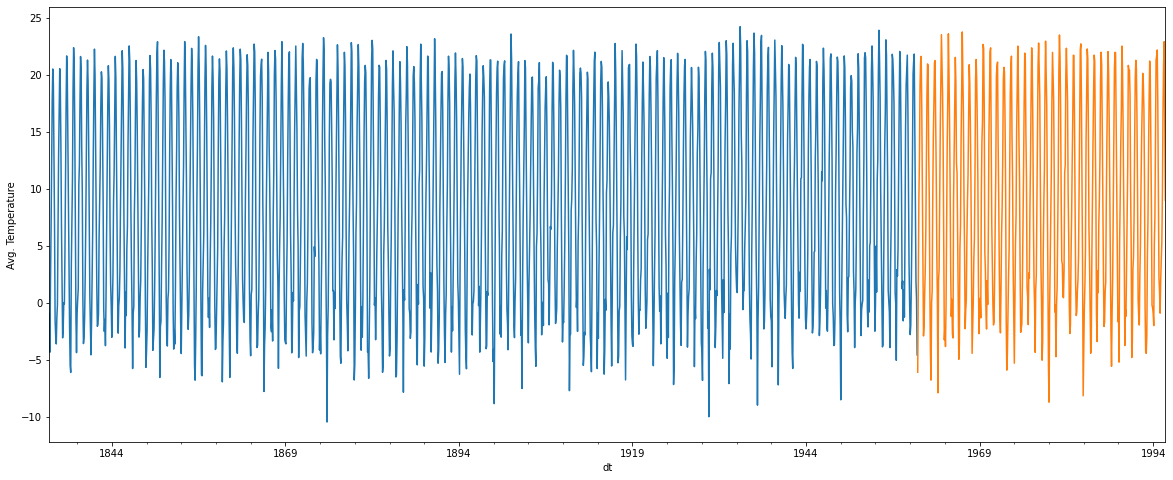

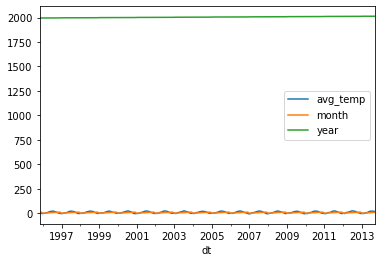

In [4]:
plot_preds(test)

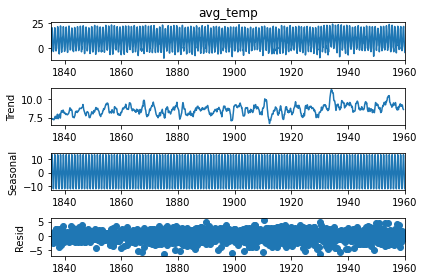

In [5]:
sm.tsa.seasonal_decompose(train.avg_temp).plot()
plt.show()


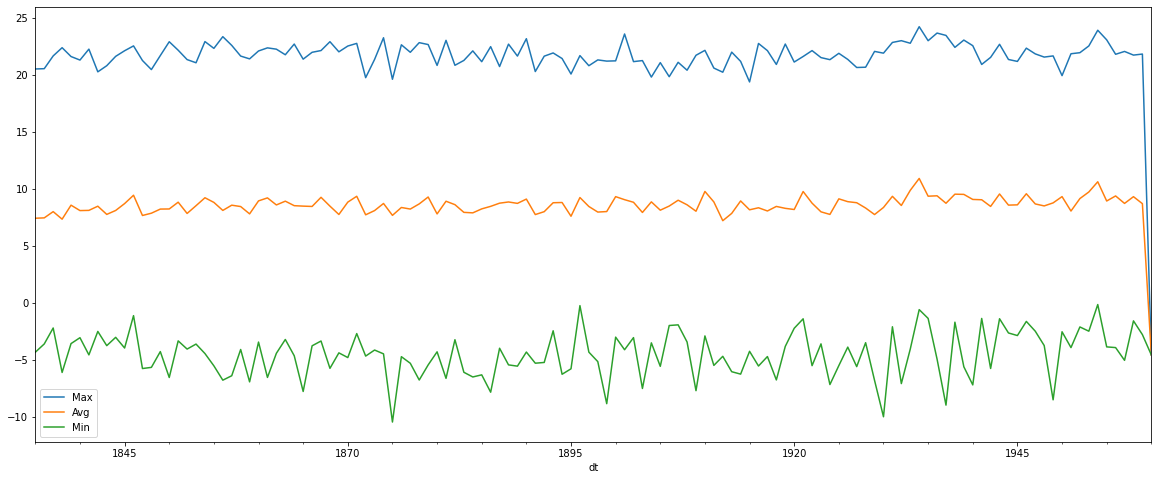

In [6]:
plt.figure(figsize=(20,8))
train.avg_temp.resample('Y').max().plot(label='Max')
train.avg_temp.resample('Y').mean().plot(label='Avg')
train.avg_temp.resample('Y').min().plot(label='Min')
plt.legend()
plt.show()

# Modeling

In [7]:
df_rmse = pd.DataFrame({'model':[],'rmse':[]}) # Make a df to store rmse values


### Last Observed Modeling

In [8]:
val['last_observed'] = train.avg_temp.iloc[-1]

/var/folders/fz/0282wvb93rn0lm_p0nscw1sm0000gn/T/ipykernel_38510/3115978171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['last_observed'] = train.avg_temp.iloc[-1]


In [9]:
def add_rmse(model,col):
    rmse = mean_squared_error(val[col],val.avg_temp)**.5
    df = pd.DataFrame({'model':[model],'rmse':[rmse]})
    return pd.concat([df_rmse,df])

In [10]:
df_rmse = add_rmse('last_observed','last_observed')
df_rmse

,model,rmse
0,last_observed,16.229832


### Simple Average

In [11]:
val['simple_avg'] = train.avg_temp.mean()

/var/folders/fz/0282wvb93rn0lm_p0nscw1sm0000gn/T/ipykernel_38510/2419380519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['simple_avg'] = train.avg_temp.mean()


In [12]:
df_rmse = add_rmse('simple_avg','simple_avg')
df_rmse

,model,rmse
0,last_observed,16.229832
0,simple_avg,8.810665


### Rolling Average

In [13]:
for r in [30,60,90]:
    val['rolling_avg_'+str(r)] = train.avg_temp.rolling(r).mean()[-1]
    df_rmse = add_rmse('rolling_avg_'+str(r),'rolling_avg_'+str(r))
df_rmse

/var/folders/fz/0282wvb93rn0lm_p0nscw1sm0000gn/T/ipykernel_38510/2394151444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['rolling_avg_'+str(r)] = train.avg_temp.rolling(r).mean()[-1]
/var/folders/fz/0282wvb93rn0lm_p0nscw1sm0000gn/T/ipykernel_38510/2394151444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['rolling_avg_'+str(r)] = train.avg_temp.rolling(r).mean()[-1]
/var/folders/fz/0282wvb93rn0lm_p0nscw1sm0000gn/T/ipykernel_38510/2394151444.py:2: SettingWithCopyWarning: 
A value is trying

,model,rmse
0,last_observed,16.229832
0,simple_avg,8.810665
0,rolling_avg_30,8.806254
0,rolling_avg_60,8.798364
0,rolling_avg_90,8.799041


### Holt

In [14]:
model = Holt(train.avg_temp,exponential=False)
model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/var/folders/fz/0282wvb93rn0lm_p0nscw1sm0000gn/T/ipykernel_38510/1804980621.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  model = model.fit(smoothing_level = .1,


In [15]:
val['holt'] = model.predict(start = val.index[0], end = val.index[-1])

/var/folders/fz/0282wvb93rn0lm_p0nscw1sm0000gn/T/ipykernel_38510/1586084797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['holt'] = model.predict(start = val.index[0], end = val.index[-1])


In [16]:
df_rmse = add_rmse('holt','holt')
df_rmse

,model,rmse
0,last_observed,16.229832
0,simple_avg,8.810665
0,rolling_avg_30,8.806254
0,rolling_avg_60,8.798364
0,rolling_avg_90,8.799041
0,holt,32.246962


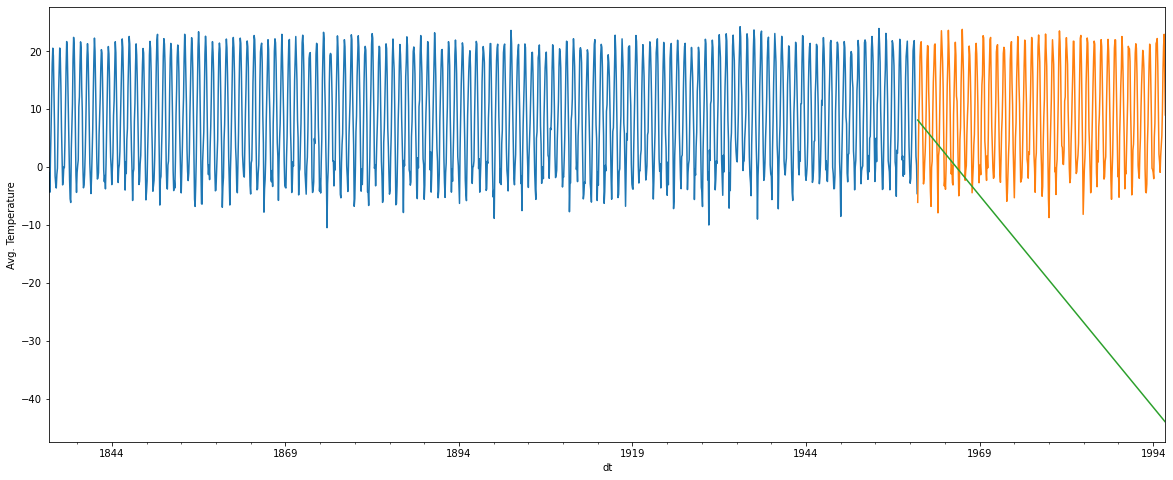

In [17]:
plot_preds(val.holt)

In [18]:
train.avg_temp + train.avg_temp.diff(365)

dt
1835-01-01       NaN
1835-02-01       NaN
1835-03-01       NaN
1835-04-01       NaN
1835-05-01       NaN
               ...  
1959-09-01    22.905
1959-10-01     3.205
1959-11-01   -14.607
1959-12-01   -21.396
1960-01-01   -30.412
Name: avg_temp, Length: 1501, dtype: float64

In [19]:
train.avg_temp.diff(365)

dt
1835-01-01       NaN
1835-02-01       NaN
1835-03-01       NaN
1835-04-01       NaN
1835-05-01       NaN
               ...  
1959-09-01     7.919
1959-10-01    -4.379
1959-11-01   -16.447
1959-12-01   -21.732
1960-01-01   -25.835
Name: avg_temp, Length: 1501, dtype: float64

In [31]:
hst = ExponentialSmoothing(train.avg_temp, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit()

/var/folders/fz/0282wvb93rn0lm_p0nscw1sm0000gn/T/ipykernel_38510/3241163499.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  hst = ExponentialSmoothing(train.avg_temp, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit()
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [32]:
val['hst'] = hst.forecast(val.shape[0])

/var/folders/fz/0282wvb93rn0lm_p0nscw1sm0000gn/T/ipykernel_38510/1440188829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['hst'] = hst.forecast(val.shape[0])


<AxesSubplot:>

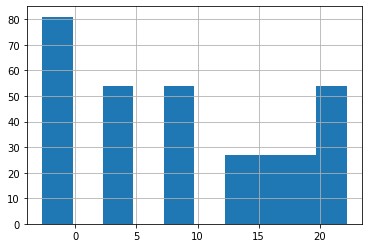

In [33]:
val.hst.hist()

In [34]:
df_rmse = add_rmse('hst','hst')

In [35]:
df_rmse

,model,rmse
0,last_observed,16.229832
0,simple_avg,8.810665
0,rolling_avg_30,8.806254
0,rolling_avg_60,8.798364
0,rolling_avg_90,8.799041
0,holt,32.246962
0,hst,1.804935
0,hst,1.779605


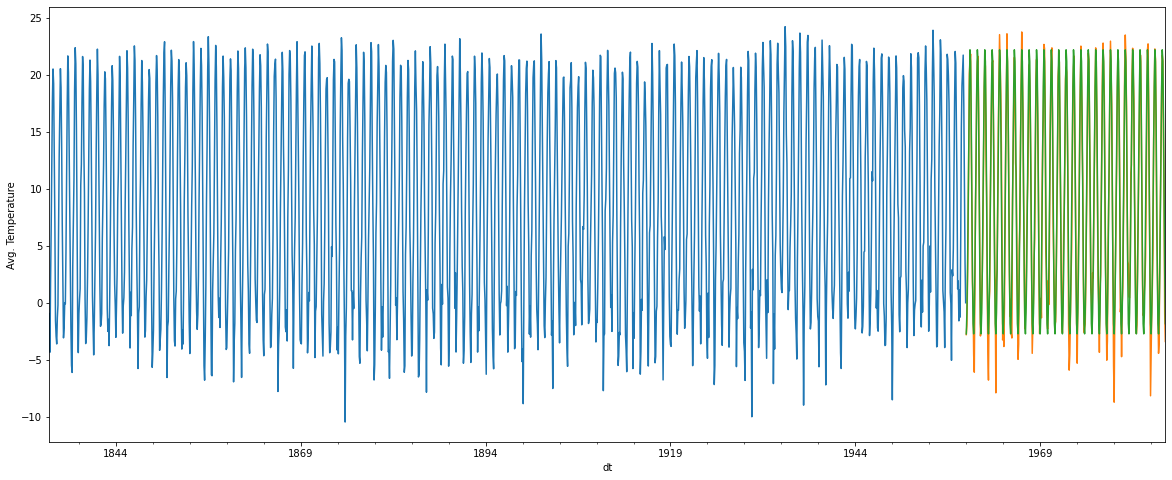

In [36]:
plot_preds(val.hst) 

In [39]:
total_preds = hst.forecast(val.shape[0]+test.shape[0])
test_preds = total_preds[-333:]

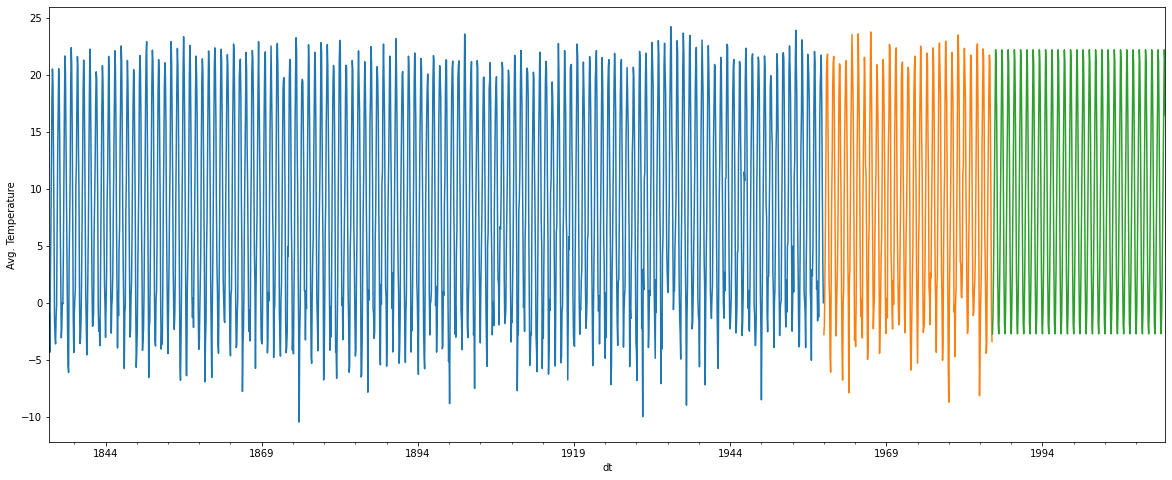

In [41]:
plot_preds(total_preds[-333:])

### RMSE of 1.06 on our Test Set

In [40]:
mean_squared_error(test_preds,test.avg_temp)**.05

1.0552449611998298

In [26]:
train = df[df.year<1959] # New split
val = df[(df.year>=1959) & (df.year<1986)]
test = df[df.year>=1986]

In [27]:
train['shift'] = train.groupby(['month'])[['avg_temp']].shift(-1)

/var/folders/fz/0282wvb93rn0lm_p0nscw1sm0000gn/T/ipykernel_38510/4271357501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['shift'] = train.groupby(['month'])[['avg_temp']].shift(-1)


In [28]:
train['dif'] = train.avg_temp - train['shift']

/var/folders/fz/0282wvb93rn0lm_p0nscw1sm0000gn/T/ipykernel_38510/807354076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['dif'] = train.avg_temp - train['shift']


In [29]:
train.head()

,avg_temp,month,year,shift,dif
dt,,,,,
1835-01-01,-0.953,1,1835,-3.611,2.658
1835-02-01,-4.337,2,1835,-1.307,-3.030
1835-03-01,1.824,3,1835,-0.205,2.029
1835-04-01,6.489,4,1835,6.432,0.057
1835-05-01,12.618,5,1835,12.826,-0.208


In [30]:
train.groupby('month')['dif'].mean()

month
1     0.005146
2    -0.044236
3     0.025049
4     0.005520
5    -0.022081
6    -0.010789
7     0.001683
8    -0.020512
9    -0.031195
10   -0.028325
11   -0.040951
12   -0.023951
Name: dif, dtype: float64